# Computer Simulations - Project 1. @ ELTE
# N-body problem of satellite formation and clustering of planetary debris inside an asteroid belt

In [417]:
import os
import random
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output, display

## Configure matplotlib and seaborn parameters

In [3]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

In [4]:
# [Mass in kg |
#  Distance from central celestail body in AU |
#  eccentricity |
#  Size in AU]
Planets={
    'Sun': [1.989e30, 0, 0.0001, 4.649e-03],
    'Moon': [7.348e22, 0.00257, 0.0549, 1.161e-05],
    'Mercury': [3.285e23, 0.466697, 0.205630, 1.631e-05],
    'Venus': [4.867e24, 0.728213, 0.006772, 4.045e-05],
    'Earth': [5.972e24, 1.017, 0.0167086, 4.259e-05],
    'Mars': [6.39e23, 1.666, 0.0934, 2.266e-05],
    'Jupiter': [1.898e27, 5.4588, 0.0489, 4.673e-04],
    'Saturn': [5.683e26, 10.1238, 0.0565, 3.893e-04],
    'Uranus': [8.681e25, 20.11, 0.046381, 1.695e-04],
    'Neptune': [1.024e26, 30.33, 0.009456, 1.646e-04],
    'Pluto': [1.309e22, 49.305, 0.2488, 7.954e-06],
    'Halley': [2.2e14, 35.082, 0.96714, 3.68e-08]
}

Planet_Colors={
    'Sun': np.array([216, 148, 29])/255,
    'Moon': np.array([204, 198, 195])/255,
    'Mercury': np.array([186, 186, 186])/255,
    'Venus': np.array([216, 194, 153])/255,
    'Earth': np.array([45, 52, 130])/255,
    'Mars': np.array([217, 120, 62])/255,
    'Jupiter': np.array([187, 155, 99])/255,
    'Saturn': np.array([222, 181, 82])/255,
    'Uranus': np.array([201, 239, 241])/255,
    'Neptune': np.array([72, 120, 242])/255,
    'Pluto': np.array([65, 25, 20])/255,
    'Halley': np.array([0,0,0])/255
}

In [311]:
# 1 AU = 149,597,871 km
AU_to_km = 149597871

## Generating small bodies

In [5]:
def sign_choose():
    return -1 if random.random() < 0.5 else 1

In [429]:
n_bodies = 10000
coordinates_array = np.zeros((n_bodies, 3))

dr = 1.5
R = 3
# Eccentricity of asteroids
# Io's eccentricity for reference and test
e = 0.0041

for i in range(n_bodies):
    # Semi-major and semi-minor axes
    a = Planets['Jupiter'][3] * (R + np.random.rand() * dr) * AU_to_km
    b = np.sqrt(a**2 * (1 - e**2))
    # c = sqrt(a^2 - b^2)
    # --> e = c/a = sqrt(1 - (b/a)^2)
    c = np.sqrt(a**2 - b**2)

    if i < n_bodies//2:
        x_coord = np.random.randint(a) * sign_choose()
        y_coord = b/a * np.sqrt(a**2 - x_coord**2) * sign_choose()
    else:
        y_coord = np.random.randint(b) * sign_choose()
        x_coord = a * np.sqrt(1 - (y_coord/b)**2) * sign_choose()

    coordinates_array[i,0] = x_coord
    coordinates_array[i,1] = y_coord
    coordinates_array[i,2] = np.random.randint(a) * 1/10 * sign_choose()

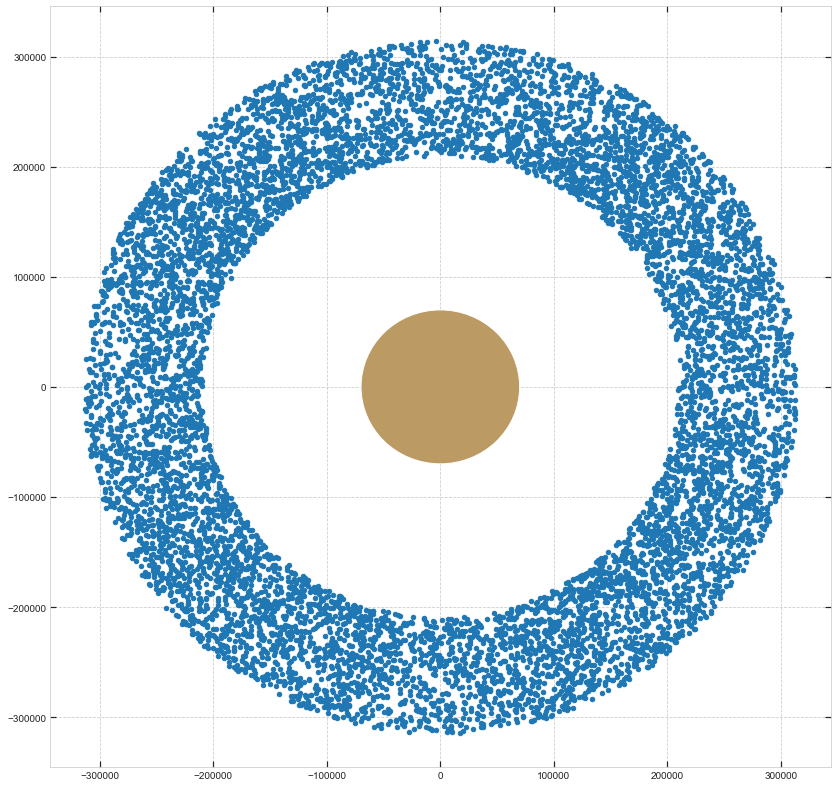

In [426]:
fig, axes = plt.subplots(figsize=(b/a*14, 14))

axes.scatter(coordinates_array[:,0], coordinates_array[:,1], s=20)

Planet_Pch = Circle(xy=(0,0), radius=Planets['Jupiter'][3] * AU_to_km, fc=Planet_Colors['Jupiter'])
axes.add_patch(Planet_Pch)

plt.show()

## 3D plot

In [427]:
def plot_visible(fig, x, y, z, points, azimuth, elev):
    #transform viewing angle to normal vector in data coordinates
    a = azimuth*np.pi/180. -np.pi
    e = elev*np.pi/180. - np.pi/2.
    X = [np.sin(e) * np.cos(a), np.sin(e) * np.sin(a), np.cos(e)]  
    # concatenate coordinates
    Z = np.c_[x, y, z]
    # calculate dot product 
    # the points where this is positive are to be shown
    cond = (np.dot(Z,X) >= 0)
    # filter points by the above condition
    x_c = x[cond]
    y_c = y[cond]
    z_c = z[cond]
    # set the new data points
    points.set_data(x_c, y_c)
    points.set_3d_properties(z_c, zdir="z")
    fig.canvas.draw_idle()

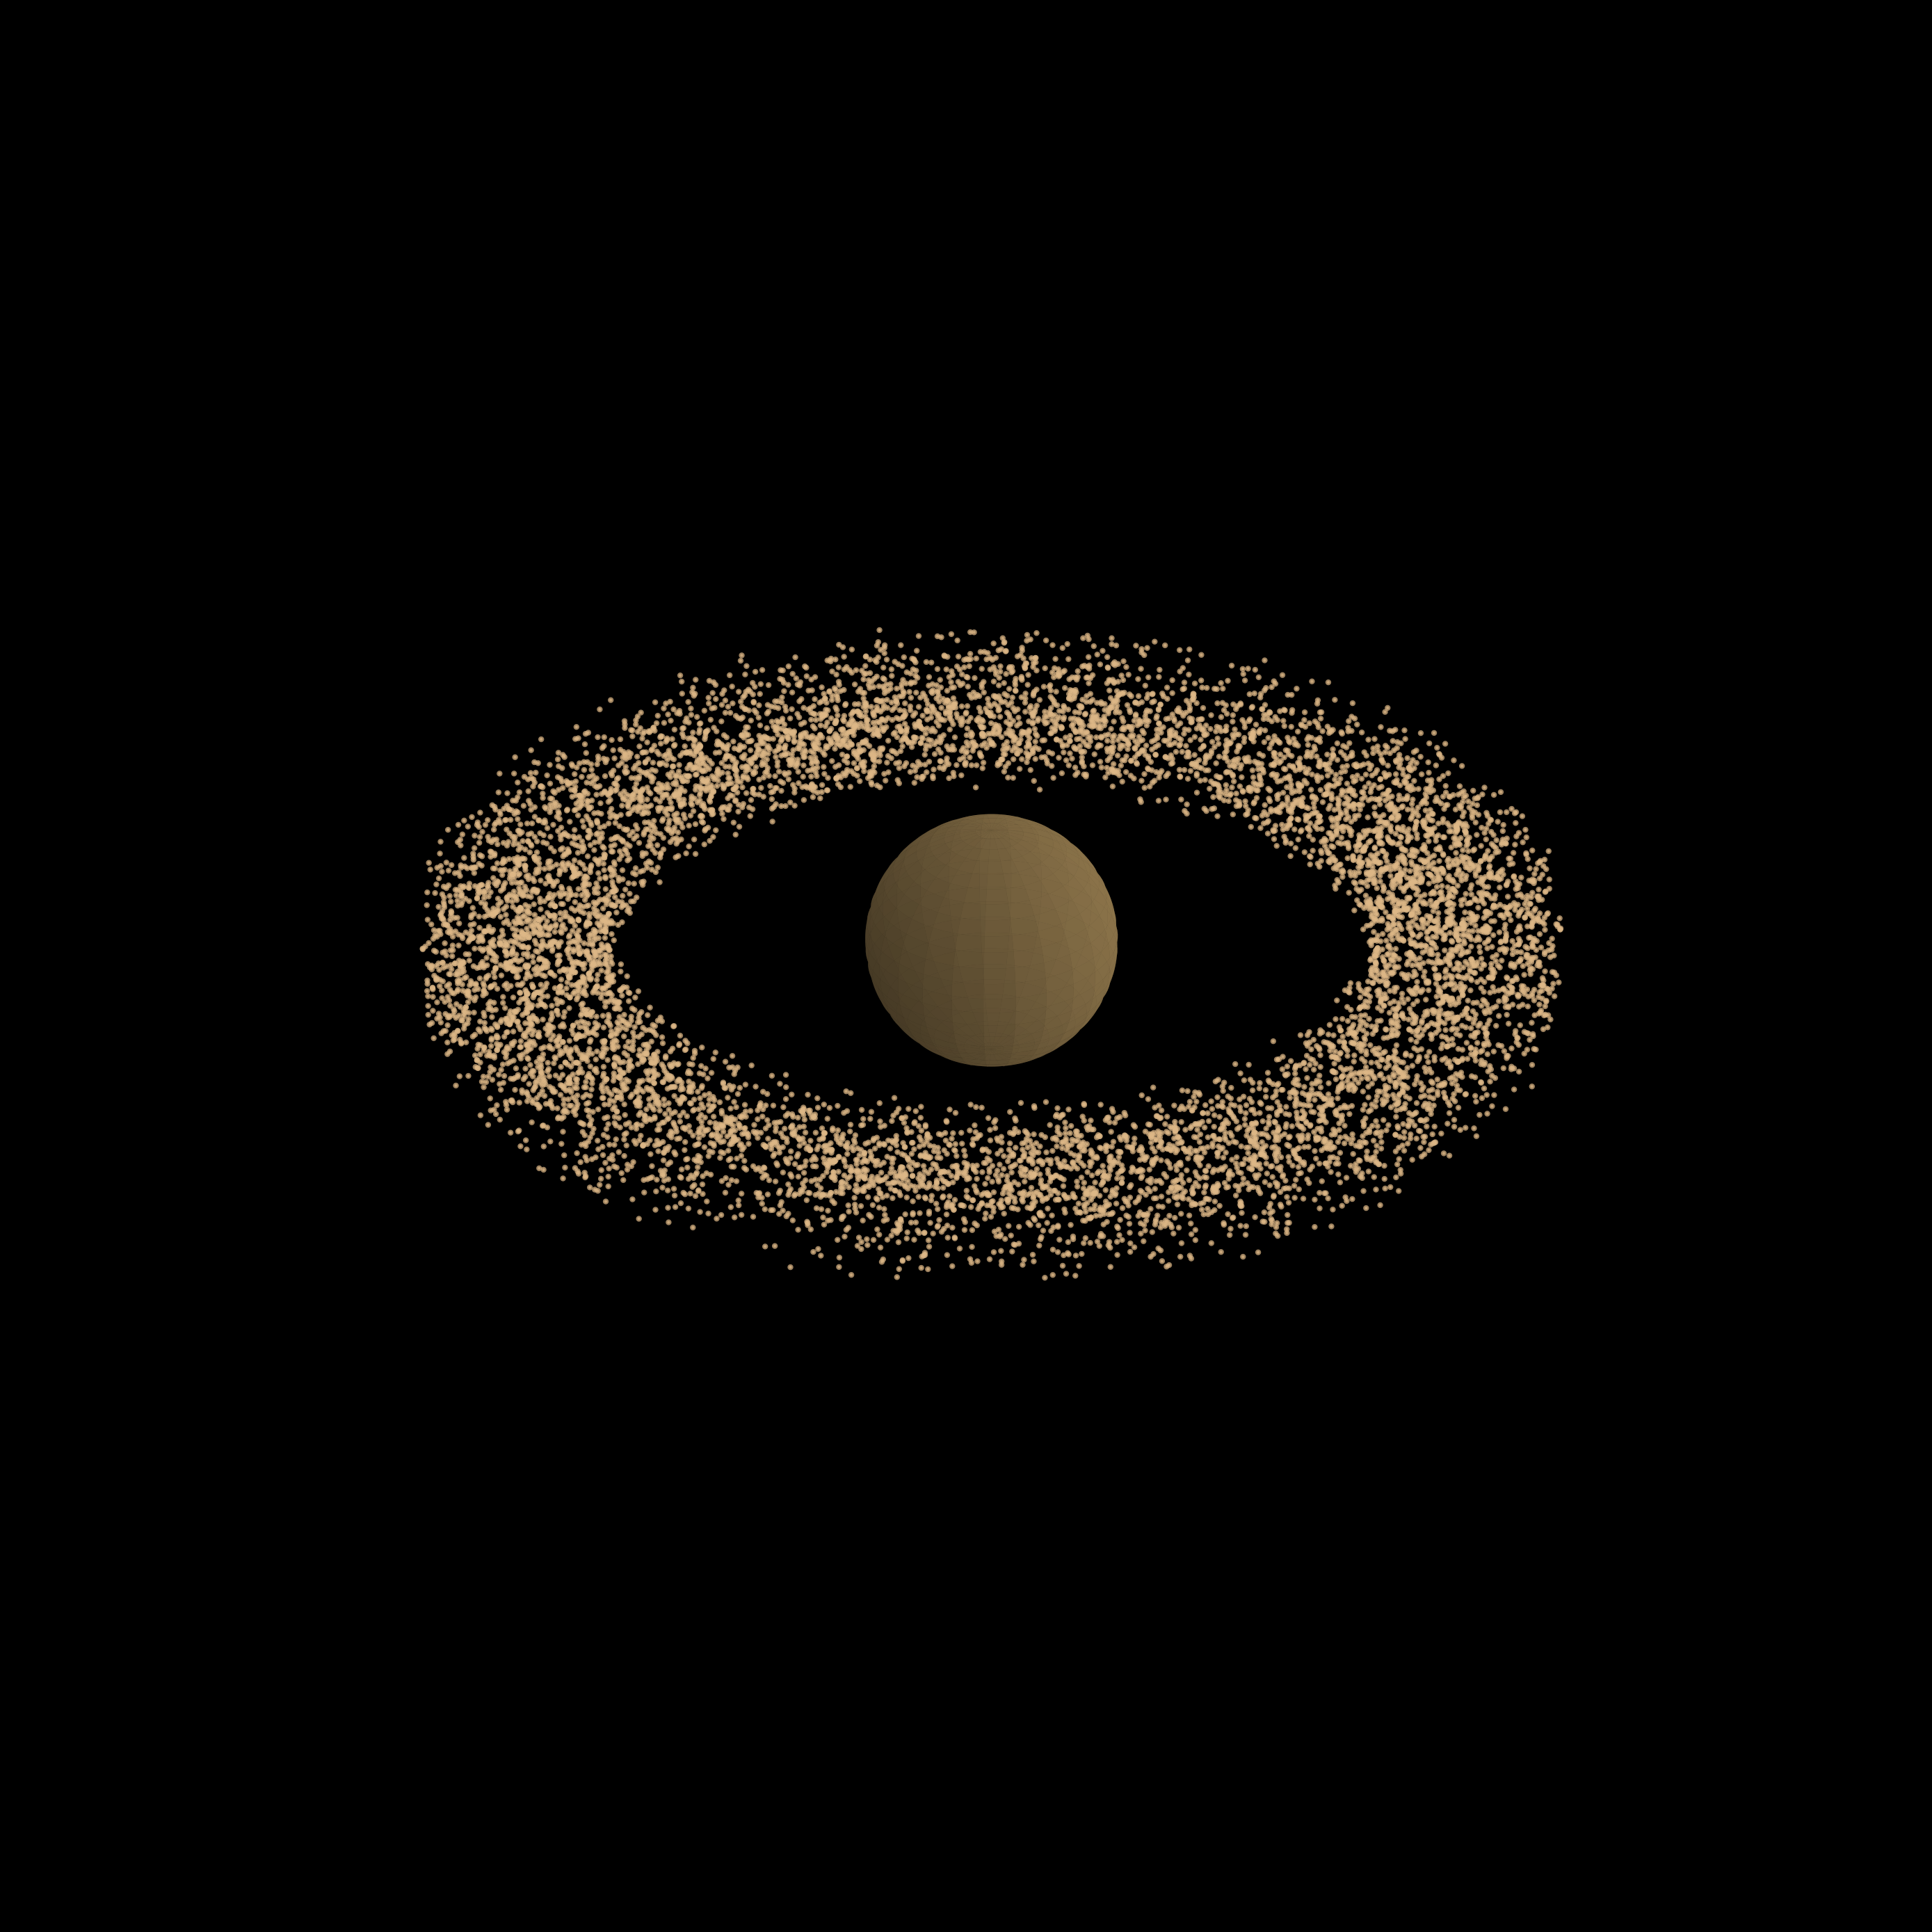

In [430]:
fig, ax = plt.subplots(figsize=(12,12), dpi=300, facecolor='black', subplot_kw={'projection' : '3d'})
ax.set_aspect('equal')

azimuth = 120
elevation = 30
ax.view_init(elevation, azimuth)
ax.set_facecolor('black')
ax.axis('off')

scale = 1.3
ax.set_xlim3d(-a*scale, a*scale)
ax.set_ylim3d(-a*scale, a*scale)
ax.set_zlim3d(-a*scale, a*scale)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Plot planet
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

r = Planets['Jupiter'][3] * AU_to_km
x = r * np.outer(np.cos(u), np.sin(v))
y = r * np.outer(np.sin(u), np.sin(v))
z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x, y, z, rstride=4, cstride=4, color=Planet_Colors['Jupiter'], linewidth=0, alpha=0.5)
ax.scatter(coordinates_array[:,0], coordinates_array[:,1], coordinates_array[:,2], color='burlywood', s=1, alpha=0.7)
"""
# Dummy plot
points, = ax.plot([],[],[], 'k.', markersize=5, alpha=0.9)
plot_visible(fig=fig,
             x=coordinates_array[:,0],
             y=coordinates_array[:,1],
             z=coordinates_array[:,2],
             points=points,
             azimuth=azimuth, elev=elevation)
"""
plt.show()